## Intro
I've chosen Animals-10 dataset for classification. As I'm working locally, it's extracted into a local `data` directory.

Here's also a link to the [repository](https://github.com/rchuk/uni_cv_classification).

In [15]:
import matplotlib.pyplot as plt

## Dataset loading #1

In [16]:
import os
import os.path as path

We can see that dataset contains `raw-img` folder with subfolder of 10 classes of animals. Each class consists of a large list of images.

There's also `translate.py` file, because folders are named in italian(?) for some reason. Maybe I should've cleaned up the dataset, by renaming the directories and writing code for downloading and extracting the dataset, but we'll keep it simple for now and use the provided file. Also it turned out the for some reason, the translation for spider was missing, so I added forked version to the git.

In [17]:
import data.translate as dataset_translate

base_dataset_path = "./data"
dataset_path = path.join(base_dataset_path, "raw-img")

def get_class_name(folder_name: str) -> str:
    return dataset_translate.translate.get(folder_name)
    
classes = sorted(os.listdir(dataset_path))
print("Classes:", list(map(get_class_name, classes)))
class_count = len(classes)
print("Class count:", class_count)
by_class_count = {get_class_name(cls): len(os.listdir(path.join(dataset_path, cls))) for cls in classes}
print("Image count by class:", by_class_count)

Classes: ['dog', 'horse', 'elephant', 'butterfly', 'chicken', 'cat', 'cow', 'sheep', 'spider', 'squirrel']
Class count: 10
Image count by class: {'dog': 4863, 'horse': 2623, 'elephant': 1446, 'butterfly': 2112, 'chicken': 3098, 'cat': 1668, 'cow': 1866, 'sheep': 1820, 'spider': 4821, 'squirrel': 1862}


For the next step, that requires us to load data and convert it into tensors, I'd like to know the resolution of the images in the dataset.

I'm afraid that if I were to select some low resolution like 128x128, I might lose a lot of details and get worse quality model.

In [18]:
from torchvision.io import read_image
from collections import Counter

resolutions = []
for root, _, files in os.walk(dataset_path):
    images = filter(lambda file: file.lower().endswith(('.png', '.jpg', '.jpeg')), files)
    paths = map(lambda file: os.path.join(root, file), images)
    for img_path in paths:
        try:
            img = read_image(img_path)
            height, width = img.shape[1], img.shape[2]
            resolutions.append((width, height))
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

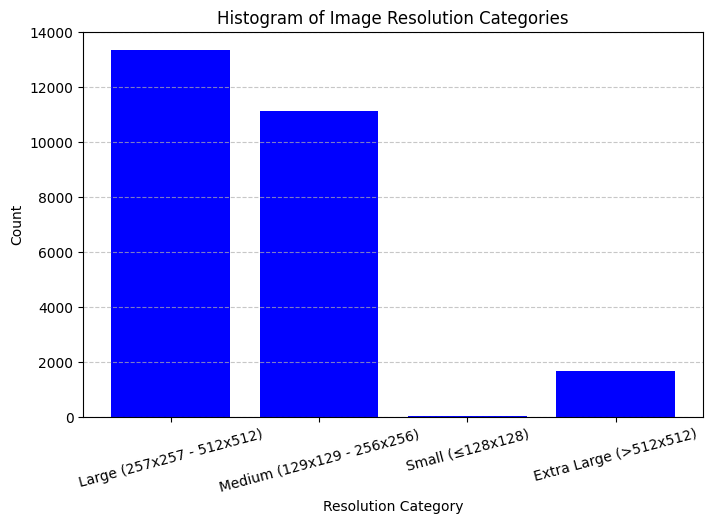

In [19]:
def categorize_resolution(width: int, height: int) -> str:
    area = width * height
    if area <= 128 * 128:
        return "Small (≤128x128)"
    elif area <= 256 * 256:
        return "Medium (129x129 - 256x256)"
    elif area <= 512 * 512:
        return "Large (257x257 - 512x512)"
    else:
        return "Extra Large (>512x512)"

resolution_categories = map(lambda x: categorize_resolution(x[0], x[1]), resolutions)
category_counts = Counter(resolution_categories)

plt.figure(figsize=(8, 5))
plt.bar(category_counts.keys(), category_counts.values(), color="blue")
plt.xlabel("Resolution Category")
plt.ylabel("Count")
plt.title("Histogram of Image Resolution Categories")
plt.xticks(rotation=15)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

So we can see that images have quite large resolution, more than 128x128 (by pixel count). But that doesn't provide us with all required information. I'd also like to know the aspect ratio of the images.

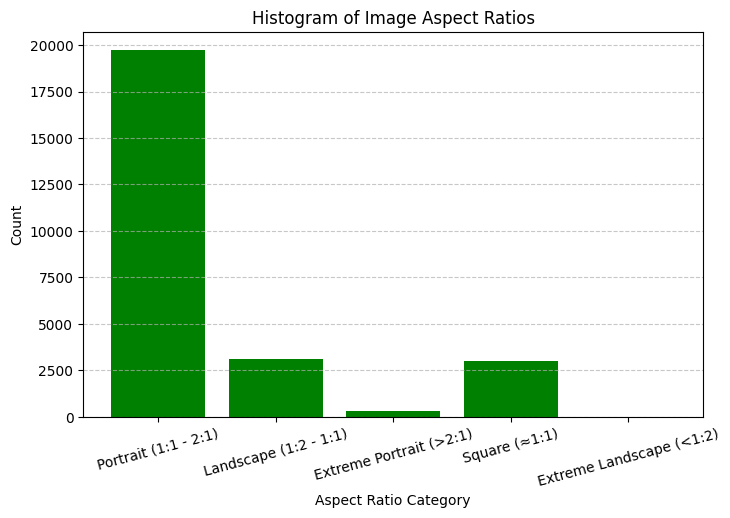

In [20]:
def categorize_aspect_ratio(width: int, height: int) -> str:
    ratio = width / height
    if 0.9 <= ratio <= 1.1:
        return "Square (≈1:1)"
    elif 1.1 < ratio <= 2:
        return "Portrait (1:1 - 2:1)"
    elif 0.5 <= ratio < 0.9:
        return "Landscape (1:2 - 1:1)"
    elif ratio > 2:
        return "Extreme Portrait (>2:1)"
    else:
        return "Extreme Landscape (<1:2)"

aspect_ratio_categories = map(lambda x: categorize_aspect_ratio(x[0], x[1]), resolutions)
aspect_ratio_counts = Counter(aspect_ratio_categories)

# Plot Aspect Ratio Histogram
plt.figure(figsize=(8, 5))
plt.bar(aspect_ratio_counts.keys(), aspect_ratio_counts.values(), color="green")
plt.xlabel("Aspect Ratio Category")
plt.ylabel("Count")
plt.title("Histogram of Image Aspect Ratios")
plt.xticks(rotation=15)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


Okay, so there are *a lot* more portrait images than anything else. There are also quite a few square images and approximately the same quantity of landscape ones.

## Dataset loading #2

In [21]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

So, considering the previous step I'll set the resolution higher than 128x128, but not up to 256x256.

In [76]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(), # I suppose animals are symmetrical in this axis :) Simplest augmentation
    transforms.RandomRotation(20), # Random rotation provides a lot of variability 
    transforms.CenterCrop(200), # I don't want to have images with black borders
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Some color jitter would be nice too
    # To be continued: Maybe I would modify this code, when I see that these augmentations are not enough
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

def denormalize(tensor):
    return tensor * 0.5 + 0.5

dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
print("Dataset:", dataset)

Dataset: Dataset ImageFolder
    Number of datapoints: 26179
    Root location: ./data\raw-img
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
               CenterCrop(size=(200, 200))
               ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.1, 0.1))
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


Now we can explore dataset in more detail.

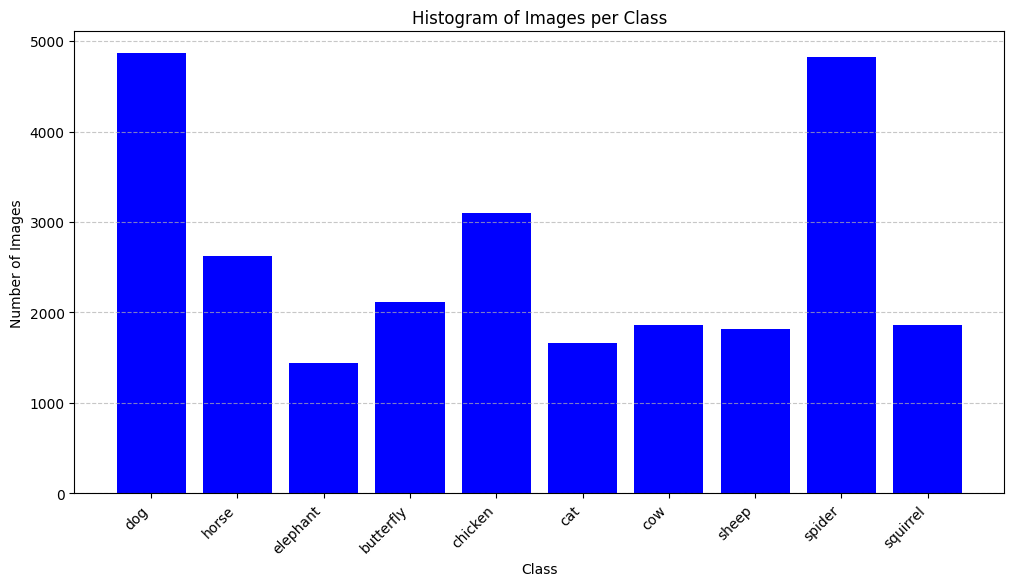

In [77]:
category_counts = Counter([get_class_name(dataset.classes[label]) for _, label in dataset.samples])

plt.figure(figsize=(12, 6))
plt.bar(category_counts.keys(), category_counts.values(), color="blue")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Histogram of Images per Class")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

Huh, there are a lot of spiders and dogs, other classes are much more balanced. Later this might present some problems with training, that should be addressed.

Surprisingly, there are also few cats. Is the author of the dataset a dog lover?

## Creating the data loaders

In [78]:
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

batch_size = 32
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Train size:", len(train_dataset))
print("Validation size:", len(val_dataset))
print("Test size:", len(test_dataset))

Train size: 18325
Validation size: 3926
Test size: 3928


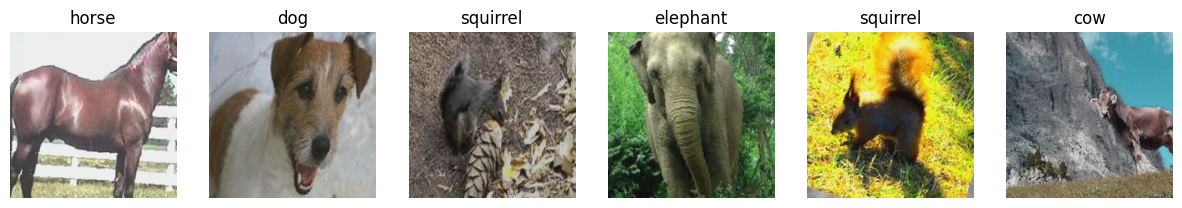

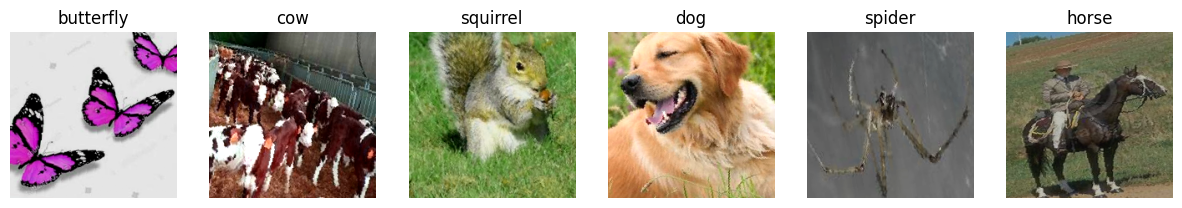

In [81]:
def show_images(dataloader, classes, num_images=6):
    images, labels = next(iter(dataloader))
    images = images[:num_images]
    labels = labels[:num_images]

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        img = denormalize(images[i]).permute(1, 2, 0).numpy()
        axes[i].imshow(img)
        axes[i].set_title(get_class_name(classes[labels[i]]))
        axes[i].axis("off")

    plt.show()

show_images(train_loader, classes)
show_images(train_loader, classes)

Looks pretty good so far.

Except I randomly stumbled on an image of some cucumber with fried potato that was classified as a chicken. Then I lost the screenshot and went on to find it. But I found even more...

![Weird image #1](data/raw-img/gallina/OIP-dDF1mtC9R9xm9NOYkrZafQHaE8.jpeg)
![Weird image #2](data/raw-img/gallina/OIP-YvKka0TCIyNPGwVatOjxkwHaFj.jpeg)
![Weird image #3](data/raw-img/gallina/OIP-1z1sRkLnG5Csiq7yNhUn5gHaFz.jpeg)

That also might present some problems and would require a dataset cleanup.

So for the next step I need to think about the model architecture, optimizator and metrics. And that's exactly what I'll do.